In [22]:
import pandas as pd
import numpy as np
import re
import itertools
import torch
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset



In [23]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)


Using device: mps


## Classify original dataset to include:
1. hdb_classification (Mature/Non-Mature)
2. storey_category (Low: 1-15/High: >=16)
3. floor_area_category (in ranges of 5sqm)

In [24]:

# Define the correct file path (adjust if needed)
file_path_final = "./resale_flat_prices_original.xlsx"

# Load the Excel file
df1 = pd.read_excel(file_path_final)

# Drop missing values
df1.dropna(inplace=True)

In [25]:
# Define mature and non-mature estates
mature_estates = [
    "ANG MO KIO", "BEDOK", "BISHAN", "BUKIT MERAH", "BUKIT TIMAH", "CENTRAL AREA",
    "CLEMENTI", "GEYLANG", "KALLANG/WHAMPOA", "MARINE PARADE", "PASIR RIS",
    "QUEENSTOWN", "SERANGOON", "TAMPINES", "TOA PAYOH"
]

non_mature_estates = [
    "BUKIT BATOK", "BUKIT PANJANG", "CHOA CHU KANG", "HOUGANG", "JURONG EAST",
    "JURONG WEST", "PUNGGOL", "SEMBAWANG", "SENGKANG", "TENGAH", "WOODLANDS", "YISHUN"
]

# Function to classify towns as mature or non-mature
def classify_town(town):
    if town.upper() in mature_estates:
        return "Mature"
    elif town.upper() in non_mature_estates:
        return "Non-Mature"
    else:
        return "Unknown"  # For any town not listed

# Function to classify storey range as Low or High
def classify_storey_range(storey_range):
    # Extract the first number from the storey range (e.g., "01 TO 03" → 1)
    try:
        first_storey = int(storey_range.split(" TO ")[0])
        return "Low" if first_storey <= 15 else "High"
    except:
        return "Unknown"  # Handle unexpected format

# Function to classify floor_area_sqm into 5sqm ranges
def classify_floor_area_sqm(floor_area_sqm):
    return (floor_area_sqm // 5) * 5

# Apply classification to the dataset
df1["hdb_classification"] = df1["town"].apply(classify_town)
df1["storey_category"] = df1["storey_range"].apply(classify_storey_range)
df1["floor_area_category"] = df1["floor_area_sqm"].apply(classify_floor_area_sqm)

# Save the updated file
# output_file_path2 = "./resale_flat_prices_classified.xlsx"
# df1.to_excel(output_file_path2, index=False)

## Aggregate classified dataset to group data by:
"month", "town", "flat_type", "street_name", "storey_category", "floor_area_category"

In [26]:
file_path2 = "./resale_flat_prices_classified.xlsx"
df2 = pd.read_excel(file_path2)
df2.dropna(inplace=True)

In [27]:
# Define mode function for categorical variables
def mode(series):
    return series.mode()[0] if not series.mode().empty else None

# Function to convert "XX years YY months" to total years as float
def convert_remaining_lease(lease_str):
    match = re.match(r"(\d+)\s+years\s+(\d+)\s+months", lease_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + (months / 12)  # Convert months to fraction of a year
    match = re.match(r"(\d+)\s+years", lease_str)
    if match:
        return int(match.group(1))  # If only years are present
    return None  # Handle unexpected formats

# Apply conversion
df2["remaining_lease"] = df2["remaining_lease"].astype(str).apply(convert_remaining_lease)

# Convert month to datetime format
df2["month"] = pd.to_datetime(df1["month"], format="%Y-%m")

# Aggregate data based on specified criteria
df2_aggregated = df2.groupby(
    ["month", "town", "flat_type", "street_name", "storey_category", "floor_area_category"]
).agg({
    "flat_model": mode,  # Most frequent flat model
    "lease_commence_date": "median",  # Median lease commence date
    "remaining_lease": "median",  # Median remaining lease
    "resale_price": "median",  # Median resale price
    "hdb_classification": mode,  # Most frequent HDB classification
}).reset_index()

# Save the updated file
# output_file_path3 = "./resale_flat_prices_aggregated.xlsx"
# df2_aggregated.to_excel(output_file_path3, index=False)

## Fill up missing data by:
1. Interpolation on numerical data
2. Mode/Forward-Fill & Backward-Fill on categorical data

Note: missing data filled in (via 1. or 2.) based on the category in a given **year**

In [28]:
file_path3 = "./resale_flat_prices_aggregated.xlsx"
df3 = pd.read_excel(file_path3)
df3.dropna(inplace=True)

In [29]:
# Step 1: Define your grouping columns
grouping_columns = ['town', 'flat_type', 'street_name', 'storey_category', 'floor_area_category']
key_columns = ['month'] + grouping_columns

# Step 2: Extract year for filtering later
df3['year'] = df3['month'].dt.year

# Step 3: Identify actual combinations with years they existed in
group_year_combos = df3[['year'] + grouping_columns].drop_duplicates()

# Step 4: Generate full grid: only fill months from years each combo actually appeared
full_grid = pd.DataFrame([
    {'month': pd.Timestamp(f"{y}-{m:02d}-01"), 'year': y, **dict(zip(grouping_columns, combo))}
    for _, row in group_year_combos.iterrows()
    for m in range(1, 13)
    for y, *combo in [row.values]  # unpack year + combo
])

# Step 5: Identify missing rows
existing_keys = df3[key_columns].drop_duplicates()
missing_keys = pd.merge(full_grid, existing_keys, how='left', indicator=True)
missing_keys = missing_keys[missing_keys['_merge'] == 'left_only'].drop(columns=['_merge'])

# Step 6: Create missing rows with NaNs for other columns
for col in df3.columns:
    if col not in missing_keys.columns:
        missing_keys[col] = pd.NA

# Step 7: Combine and interpolate
df3_full = pd.concat([df3, missing_keys], ignore_index=True)

# Interpolate and fill
numeric_cols = ['lease_commence_date', 'remaining_lease', 'resale_price']
non_numeric_cols = ['flat_model', 'hdb_classification']
grouping_with_year = grouping_columns + ['year']

# Interpolate numeric columns ONLY where there are NaNs
for col in numeric_cols:
    df3_full[col] = df3_full.groupby(grouping_with_year)[col].transform(
        lambda x: x if x.notna().all() else x.interpolate()
    )

# Fill non-numeric columns ONLY where there are NaNs
for col in non_numeric_cols:
    df3_full[col] = df3_full.groupby(grouping_with_year)[col].transform(
        lambda x: x if x.notna().all() else x.fillna(x.mode()[0] if not x.mode().empty else pd.NA)
    )
    df3_full[col] = df3_full[col].ffill().bfill()

# Drop 'year' if still present
if 'year' in df3_full.columns:
    df3_full = df3_full.drop(columns=['year'])

df3_full = df3_full.sort_values('month').reset_index(drop=True)

# Save the interpolated dataset
# output_file_path4 = "./resale_flat_prices_final.xlsx"
# df3_full.to_excel(output_file_path4, index=False)

/var/folders/5x/zyxhwl456zgdlj_lrsfyy9qm0000gn/T/ipykernel_69732/3564943248.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df3_full = pd.concat([df3, missing_keys], ignore_index=True)


## Encoding of non-numerical data:
1. One-hot vector encoding for town, flat_type, storey_category, flat_model and hdb_classification
2. nn.embeddings for street_name

In [30]:
file_path4 = "./resale_flat_prices_final.xlsx"
df4 = pd.read_excel(file_path4)
df4.dropna(inplace=True)

In [31]:
# Get number of unique values
num_unique_towns = df4['town'].nunique()
num_unique_flat_types = df4['flat_type'].nunique()
num_unique_storey_categories = df4['storey_category'].nunique()
num_unique_streets = df4['street_name'].nunique()
num_unique_flat_models = df4['flat_model'].nunique()
num_unique_hdb_classifications = df4['hdb_classification'].nunique()

print("Number of unique towns:", num_unique_towns)
print("Number of unique flat types:", num_unique_flat_types)
print("Number of unique storey categories:", num_unique_storey_categories)
print("Number of unique street names:", num_unique_streets)
print("Number of unique flat models:", num_unique_flat_models)
print("Number of unique HDB classifications:", num_unique_hdb_classifications)

Number of unique towns: 26
Number of unique flat types: 7
Number of unique storey categories: 2
Number of unique street names: 571
Number of unique flat models: 21
Number of unique HDB classifications: 2


In [32]:
# One-hot encode town, flat_type, storey_category, flat_model and hdb_classification
town_ohe = pd.get_dummies(df4['town']).values.astype(int).tolist()
flat_type_ohe = pd.get_dummies(df4['flat_type']).values.astype(int).tolist()
storey_category_ohe = pd.get_dummies(df4['storey_category']).values.astype(int).tolist()
flat_model_ohe = pd.get_dummies(df4['flat_model']).values.astype(int).tolist()
hdb_classification_ohe = pd.get_dummies(df4['hdb_classification']).values.astype(int).tolist()

df4['town_one_hot'] = town_ohe
df4['flat_type_one_hot'] = flat_type_ohe
df4['storey_category_one_hot'] = storey_category_ohe
df4['flat_model_one_hot'] = flat_model_ohe
df4['hdb_classification_one_hot'] = hdb_classification_ohe

# Encode street_names as indices
street_name_to_idx = {name: idx for idx, name in enumerate(df4['street_name'].unique())}
df4['street_name_idx'] = df4['street_name'].map(street_name_to_idx)

# Create embedding layer and apply to indices
num_street_names = len(street_name_to_idx)
embedding_dim = 16
embedding_layer = nn.Embedding(num_street_names, embedding_dim)

# Convert to tensor and pass through embedding layer
street_indices_tensor = torch.tensor(df4['street_name_idx'].tolist(), dtype=torch.long)
street_embeddings = embedding_layer(street_indices_tensor)

# Convert embedding vectors to list and store in DataFrame
df4['street_name_embed'] = street_embeddings.detach().numpy().tolist()

# Save the final DataFrame with one-hot vectors and embeddings
# output_file_path5 = "./resale_flat_prices_one_hot_vector_and_embed.xlsx"
# df4.to_excel(output_file_path5, index=False)

## Generate Static Vector

Static vectors are made from 
- 'town_one_hot', 
- 'flat_type',
- 'street_name_embed',
- 'storey_category', 
- 'floor_area_category', 
- 'flat_model_one_hot', 
- 'lease_commence_date',
- 'hdb_classification_one_hot' 

Row entries in this 'static vector' column can be thought of as a HDB flat profile

In [33]:
file_path5 = "./resale_flat_prices_one_hot_vector_and_embed.xlsx"
df_final = pd.read_excel(file_path5)
df_final.dropna(inplace=True)

In [34]:
# Check data type for each static feature
static_features = [
    'town_one_hot', # str
    'flat_type_one_hot', #str
    'street_name_embed', # str
    'storey_category_one_hot', #str
    'floor_area_category', #numpy.int64
    'flat_model_one_hot', #str
    'lease_commence_date',#numpy.float64
    'hdb_classification_one_hot' #str
]
for feature in static_features:
  x=type(df_final.loc[0, feature])
  print(feature,x)


town_one_hot <class 'str'>
flat_type_one_hot <class 'str'>
street_name_embed <class 'str'>
storey_category_one_hot <class 'str'>
floor_area_category <class 'numpy.int64'>
flat_model_one_hot <class 'str'>
lease_commence_date <class 'numpy.float64'>
hdb_classification_one_hot <class 'str'>


In [35]:
numeric_columns_to_fix = [
    'town_one_hot',
    'flat_model_one_hot',
    'street_name_embed',
    'storey_category_one_hot',
    'flat_type_one_hot',
    'hdb_classification_one_hot'
]

for col in numeric_columns_to_fix:
    df_final[col] = df_final[col].apply(ast.literal_eval)


In [36]:
counter =0 
for feature in static_features:
    sample = df_final.loc[0, feature]
    
    if isinstance(sample, list):
        length = len(sample)
        counter += length
    else:
        length = 1  # scalar (int, float, one-hot already mapped)
        counter += length
    
    print(f"{feature}: {length} dimensions")
print("Total dimensions for static features:", counter)

town_one_hot: 26 dimensions
flat_type_one_hot: 7 dimensions
street_name_embed: 16 dimensions
storey_category_one_hot: 2 dimensions
floor_area_category: 1 dimensions
flat_model_one_hot: 21 dimensions
lease_commence_date: 1 dimensions
hdb_classification_one_hot: 2 dimensions
Total dimensions for static features: 76


In [37]:
# Function to create static vector
def flatten_static_features(row):
    return torch.tensor(
        row['town_one_hot'] +
        row['flat_model_one_hot'] +
        row['hdb_classification_one_hot'] +
        row['street_name_embed'] +
        row['flat_type_one_hot'] +
        row['storey_category_one_hot']+
        [
            row['lease_commence_date'],
            row['floor_area_category'],
        ],
        dtype=torch.float32
    )

# Apply flatten_static_features function to every row in df_final
df_final['static_vector'] = df_final.apply(flatten_static_features, axis=1)

input_dim = len(df_final.loc[0, 'static_vector'])
print("Feedforward input dim:", input_dim)

# Sanity check: We now have column - static_vector - where every row is a 76 dimension tensor
df_final['static_vector']


Feedforward input dim: 76


0         [tensor(1.), tensor(0.), tensor(0.), tensor(0....
1         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
                                ...                        
391147    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391148    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391149    [tensor(0.), tensor(1.), tensor(0.), tensor(0....
391150    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391151    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
Name: static_vector, Length: 391152, dtype: object

## Define Train - Test - Val split



In [38]:

''' 
    Split dataset by flat profile. So each group is a flat profile with multiple months of data.
    Then sort each group by month to process the data in true chronological order
    Split each group into train, val, and test sets
    - Train: Before COVID
    - Val: 0-2 year after Singapore's phase 3 lockdown - when most restrictions were lifted
    - Test: After all lockdown measures were lifted
'''

# Ensure 'month' column is datetime
df_final['month'] = pd.to_datetime(df_final['month'])

# Define COVID cutoff points
covid_start = pd.to_datetime("2020-01-01")

# End of Singapore's Phase 3 lockdown - when most restrictions were lifted
val_start = pd.to_datetime("2021-01-01")

# When lockdown measures were lifted
val_cutoff = pd.to_datetime("2023-01-01")   
test_start = pd.to_datetime("2023-01-01")  

# Split globally across all static profiles
df_train = df_final[df_final['month'] < covid_start].reset_index(drop=True)
df_val = df_final[(df_final['month'] >= val_start) & (df_final['month'] < val_cutoff)].reset_index(drop=True)
df_test = df_final[df_final['month'] >= test_start].reset_index(drop=True)

# ✅ Final sanity check
print(f"Train size: {len(df_train)} (Pre-COVID)")
print(f"Validation size: {len(df_val)} (End of Singapore's Phase 3 lockdown)")
print(f"Test size: {len(df_test)} (After all lockdown measures lifted)")


Train size: 129576 (Pre-COVID)
Validation size: 96324 (End of Singapore's Phase 3 lockdown)
Test size: 120588 (After all lockdown measures lifted)


# Filtering Step: Long-Term Static Profiles

Objective:
Retain static profiles (i.e., unique combinations of static features) that have at least 12 consecutive months of historical data.

Why This Matters:
Aggregating diverse rows under the same static profile can lead to short or fragmented time series, which are unsuitable for training sliding window models. By enforcing a minimum sequence length of 12 months, we ensure the model has sufficient historical context for learning meaningful temporal patterns.

In [39]:
def filter_valid_static_profiles(df,df_name, min_months=12, min_streak=12):
    """
    Filters out static profiles with fewer than `min_months = 12` total rows 
    or lacking a contiguous streak of at least `min_streak = 12` months.

    Parameters:
    - df: DataFrame with 'month' and 'static_vector' columns
    - min_months: Minimum total rows per profile (default=12)
    - min_streak: Minimum consecutive monthly streak (default=12)
    - drop_duplicates: Whether to keep only one row per static vector

    Returns:
    - Filtered DataFrame with valid static profiles
    """

    # Step 1: Ensure datetime format and static_tuple column
    df['month'] = pd.to_datetime(df['month'])
    df['static_tuple'] = df['static_vector'].apply(lambda x: tuple(x.tolist()))

    # Step 2: Filter by total months

    # Obtain counts of each static profile
    profile_counts = df['static_tuple'].value_counts()
    # Filter profiles with fewer than min_months
    valid_profiles_by_length = profile_counts[profile_counts > min_months].index
    # Filter the DataFrame to keep only valid profiles
    df = df[df['static_tuple'].isin(valid_profiles_by_length)].copy()

    # Step 3: Filter by contiguous streak
    grouped = df.groupby('static_tuple')
    valid_contiguous_profiles = []

    for static_key, group in grouped:
        # Sort static profile in chronological order
        months = group['month'].sort_values().reset_index(drop=True)

        # Calculate the difference in days between consecutive months
        deltas = months.diff().dropna().dt.days

        streak = 1
        max_streak = 1
        for gap in deltas:
            # If the difference is 31 days or less, it's a contiguous month
            if gap <= 31:  
                streak += 1
                max_streak = max(max_streak, streak)
            else:
                # Reset streak if gap is larger than 31 days
                streak = 1

        if max_streak >= min_streak:
            valid_contiguous_profiles.append(static_key)

    df = df[df['static_tuple'].isin(valid_contiguous_profiles)].copy()

    

    # Step 5: Logging
    print(f"Dataset: named {df_name}")
    print(f"Filtered dataset size: {len(df)}")

    return df


df_train = filter_valid_static_profiles(df_train,"train")
df_val   = filter_valid_static_profiles(df_val,"val")
df_test  = filter_valid_static_profiles(df_test,"test")



Dataset: named train
Filtered dataset size: 84338
Dataset: named val
Filtered dataset size: 51944
Dataset: named test
Filtered dataset size: 79060


In [40]:
df_train.head()


,month,town,flat_type,street_name,storey_category,floor_area_category,flat_model,lease_commence_date,remaining_lease,resale_price,hdb_classification,town_one_hot,flat_type_one_hot,storey_category_one_hot,flat_model_one_hot,hdb_classification_one_hot,street_name_idx,street_name_embed,static_vector,static_tuple
0,2017-01-01,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,Low,40,Improved,1979.0,61.333333,232000.0,Mature,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0]","[0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0]",0,"[-0.6664201617240906, 1.2729698419570923, -0.5...","[tensor(1.), tensor(0.), tensor(0.), tensor(0....","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 21,Low,170,Apartment,1993.0,75.000000,720000.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",1,"[0.8844636082649231, -0.7062023878097534, -0.0...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 31,Low,140,Apartment,1985.0,66.916667,625000.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",2,"[0.606955349445343, -0.5171763896942139, -1.36...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 31,Low,145,Maisonette,1985.0,66.833333,692500.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",2,"[0.606955349445343, -0.5171763896942139, -1.36...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2017-01-01,JURONG EAST,EXECUTIVE,TOH GUAN RD,Low,145,Maisonette,1998.0,80.333333,792000.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",3,"[1.3140616416931152, 0.9579971432685852, -0.44...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Normalize Non-static features

Price and Remaining Lease

In [41]:
def normalize_price_and_lease(df):
    """
    Normalizes 'resale_price' and 'remaining_lease' columns using mean and std from training set.

    Parameters:
    - df : DataFrame containing 'resale_price' and 'remaining_lease' columns

    Returns:
    - DataFrame with normalized columns
    """

    # Compute normalization stats from training set
    resale_mean = df['resale_price'].mean()
    resale_std = df['resale_price'].std()
    lease_mean = df['remaining_lease'].mean()
    lease_std = df['remaining_lease'].std()


    df['resale_price_normalized'] = (df['resale_price'] - resale_mean) / resale_std
    df['remaining_lease_normalized'] = (df['remaining_lease'] - lease_mean) / lease_std
    

    return  df
df_final = normalize_price_and_lease(df_final)
df_train = normalize_price_and_lease(df_train)
df_val = normalize_price_and_lease(df_val)
df_test = normalize_price_and_lease(df_test)


In [42]:
# Sanity check
df_train['resale_price_normalized']

0        -1.483587
1         1.283756
2         0.745032
3         1.127810
4         1.692053
            ...   
129571   -1.273768
129572   -1.401361
129573   -1.239743
129574   -1.171694
129575   -1.330476
Name: resale_price_normalized, Length: 84338, dtype: float64

## Create Feedforward layer using static vectors

In [43]:

# Define the feedforward model
class StaticFFModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(input_dim, 128), # Hyperparameter
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.ff(x)

# Create instance
static_ff = StaticFFModel(input_dim=76, output_dim=76) # Note we should modify the output dimension to fit the hidden layer of the LSTM model. 

# Move model to MPS (or CUDA/CPU depending on your setup)
static_ff = static_ff.to(device)

#processing df_train
static_tensor_batch = torch.stack(df_train['static_vector'].tolist()).to(device)  
feedforward_output_train = static_ff(static_tensor_batch)
df_train['static_embedding'] = feedforward_output_train.detach().cpu().tolist()

#processing df_val
static_tensor_batch = torch.stack(df_val['static_vector'].tolist()).to(device)
feedforward_output_val = static_ff(static_tensor_batch)
df_val['static_embedding'] = feedforward_output_val.detach().cpu().tolist()

#processing df_test
static_tensor_batch = torch.stack(df_test['static_vector'].tolist()).to(device)
feedforward_output_test = static_ff(static_tensor_batch)
df_test['static_embedding'] = feedforward_output_test.detach().cpu().tolist()

print ("Train set with static embedding shape:", df_train['static_embedding'].apply(lambda x: len(x)).unique())
print ("Val set with static embedding shape:", df_val['static_embedding'].apply(lambda x: len(x)).unique())
print ("Test set with static embedding shape:", df_test['static_embedding'].apply(lambda x: len(x)).unique())



Train set with static embedding shape: [76]
Val set with static embedding shape: [76]
Test set with static embedding shape: [76]


# Sliding Window

In [44]:
def generate_sequences(df, window_size=12):
    x_combined_list = []
    y_list = []

    grouped = df.groupby("static_tuple")

    for _, group in grouped:
        group = group.sort_values("month").reset_index(drop=True)

        if len(group) < window_size + 1:
            continue  # not enough data to create a window
        

        for i in range(len(group) - window_size):
            # Select 12 rows of data at row i, with 2 columns: resale_price and remaining_lease
            # x_window.shape = [12, 2]
            x_window = group.loc[i:i+window_size-1, ["resale_price_normalized", "remaining_lease_normalized"]].values
            
        
            # Obtain static embedding at time t+1
            # repeat for 12 time steps
            x_static = group.loc[i+window_size, "static_embedding"]
            x_static_repeated = np.tile(x_static, (window_size, 1))  
            
            # Concatenate dynamic and static features 
            x_combined = np.concatenate([x_window, x_static_repeated], axis=1)

            # Target: resale_price at time t+1
            y = group.loc[i+window_size, "resale_price_normalized"]

            x_combined_list.append(x_combined) # Store input 
            y_list.append(y) #Store output

    # Convert to tensors
    X_tensor = torch.tensor(np.array(x_combined_list), dtype=torch.float32)  # [N, 12, 76]
    y_tensor = torch.tensor(np.array(y_list), dtype=torch.float32)           # [N]

    return X_tensor, y_tensor


In [45]:
X_train, y_train = generate_sequences(df_train)
X_val, y_val = generate_sequences(df_val)
X_test, y_test = generate_sequences(df_test)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: torch.Size([49862, 12, 78]) torch.Size([49862])
Val shape: torch.Size([24728, 12, 78]) torch.Size([24728])
Test shape: torch.Size([43492, 12, 78]) torch.Size([43492])


In [46]:
def get_tensor_loader(X_tensor, y_tensor, batch_size=32, shuffle=True):
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [47]:
train_loader = get_tensor_loader(X_train, y_train, batch_size=32, shuffle=True)
val_loader = get_tensor_loader(X_val, y_val, batch_size=32, shuffle=False)
test_loader = get_tensor_loader(X_test, y_test, batch_size=32, shuffle=False)


## Save train, val and test dataframes

In [48]:
# Save train, val, and test dataframes
# df_train.to_csv("train_data.csv", index=False)
# df_val.to_csv("val_data.csv", index=False)
# df_test.to_csv("test_data.csv", index=False)

# LSTM

In [49]:
class LSTMEncoder(nn.Module):
    def __init__(self, non_static_dim, static_embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        input_dim = non_static_dim + static_embedding_dim
        self.lstm = nn.LSTM(
            input_size=input_dim, # 2 +76 (dynamic + static) = 78 
            hidden_size=hidden_dim, # Hyperparameter
            num_layers=num_layers, # Hyperparameter
            batch_first=True # input tensor (x) shape is set to [batch_size, sequence_length, input_dim]
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        # out is the hidden state for all time steps
        # hidden = (hn, cn), for simplicity
        # hn is the hidden state for the last time step 
        # cn is the cell state (long term history for the last time step
        out, hidden = self.lstm(x)
        return hidden  # Return full hidden & cell states
    


In [50]:
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_dim, static_embedding_dim, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = output_dim + static_embedding_dim  # 1 + 76
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, target_len, static_embed, hidden, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):
        """
        Inputs:
        - target_len: length of the target sequence:, how many resale prices to predict ? 
        - static_embed: [B, 64] - static embedding repeated for each time step 
        - hidden = (hn, cn): states from encoder
        - teacher_forcing_inputs: [B, target_len] optional ground truth inputs values 
        - teacher_forcing_ratio: how often to use ground truth vs predicted values 
        Returns:
        - outputs: [B, target_len]
        """
        batch_size = static_embed.size(0) # Batch size 
        output_dim = self.fc.out_features # 1 
        outputs = []

        # First input: zero resale price
        input_step = torch.zeros(batch_size, 1, output_dim).to(static_embed.device)

        # Run the decoder target_len times 
        # If we want a prediction 5 years ahead, target_len = 60
        for t in range(target_len):
            # Concatenate static embedding to every input
            static_t = static_embed.unsqueeze(1)  # [B, 1, 76]
            lstm_input = torch.cat([input_step, static_t], dim=2)  # [B, 1, 1+76]

            out, hidden = self.lstm(lstm_input, hidden)  # out: [B, 1, H]
            output = self.fc(out)  # [B, 1, 1]
            outputs.append(output.squeeze(1))  # [B, 1] → squeeze time dim

            # Decide whether to use teacher forcing
            # When training, we can use teacher forcing to improve convergence
            # When doing inference into the future, we use the predicted value
            if teacher_forcing_inputs is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_step = teacher_forcing_inputs[:, t].unsqueeze(1).unsqueeze(-1)  # [B, 1, 1]
            else:
                input_step = output  # Autoregressive prediction 

        return torch.cat(outputs, dim=1)  # [B, target_len]


In [51]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        return self.decoder(
            target_len=target_len,
            static_embed=static_embed,
            hidden=hidden,
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )


def train_epoch(model, dataloader, optimizer, criterion, device, target_len=1, teacher_forcing=True):
    model.train()
    total_loss = 0

    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)             
        y_batch = y_batch.to(device)          

        static_embed = x_batch[:, 0, -76:]        # extract static embedding (same across all time steps)

        # If teacher forcing, use the ground truth values for the next time step 
        # Else use the predicted values
        teacher_inputs = y_batch.unsqueeze(1) if teacher_forcing else None  

        optimizer.zero_grad()
        outputs = model(
            x_batch,
            static_embed,
            target_len=target_len,
            teacher_forcing_inputs=teacher_inputs,
            teacher_forcing_ratio=0.5 if teacher_forcing else 0.0 # Hyperparameter
        )

        # If multi-step: criterion on all time steps; if single-step: squeeze
        if target_len == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)




In [52]:
def validate_epoch(model, dataloader, criterion, device, resale_mean, resale_std, target_len=1):
    model.eval()
    total_loss = 0
    preds = []
    trues = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            static_embed = x_batch[:, 0, -76:]

            outputs = model(
                x_batch,
                static_embed,
                target_len=target_len,
                teacher_forcing_inputs=None,
                teacher_forcing_ratio=0.0
            )

            if target_len == 1:
                outputs = outputs.squeeze(1)

            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            preds.append(outputs.cpu())
            trues.append(y_batch.cpu())

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()

    # Denormalize
    preds_denorm = preds * resale_std + resale_mean
    trues_denorm = trues * resale_std + resale_mean

    # Compute metrics
    mae = np.mean(np.abs(trues_denorm - preds_denorm))
    ss_res = np.sum((trues_denorm - preds_denorm) ** 2)
    ss_tot = np.sum((trues_denorm - np.mean(trues_denorm)) ** 2)
    r2 = 1 - ss_res / ss_tot

    return total_loss / len(dataloader), mae, r2, preds_denorm, trues_denorm


In [53]:
def plot_predictions(true_values, predicted_values, title="Validation Predictions"):
    plt.figure(figsize=(6, 6))
    plt.scatter(true_values, predicted_values, alpha=0.3)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()], 'r--')
    plt.xlabel("True Resale Price")
    plt.ylabel("Predicted Resale Price")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1 | Train Loss: 0.3778 | Val Loss: 0.1195 | MAE: 51064.87 | R²: 0.89
Epoch 2 | Train Loss: 0.0526 | Val Loss: 0.0841 | MAE: 42428.90 | R²: 0.92
Epoch 3 | Train Loss: 0.0455 | Val Loss: 0.0642 | MAE: 37303.26 | R²: 0.94
Epoch 4 | Train Loss: 0.0370 | Val Loss: 0.0453 | MAE: 30119.70 | R²: 0.96
Epoch 5 | Train Loss: 0.0339 | Val Loss: 0.0372 | MAE: 26100.19 | R²: 0.96
Epoch 6 | Train Loss: 0.0331 | Val Loss: 0.0592 | MAE: 37295.80 | R²: 0.94
Epoch 7 | Train Loss: 0.0310 | Val Loss: 0.0339 | MAE: 23410.71 | R²: 0.97
Epoch 8 | Train Loss: 0.0321 | Val Loss: 0.0541 | MAE: 33705.26 | R²: 0.95
Epoch 9 | Train Loss: 0.0331 | Val Loss: 0.0410 | MAE: 26401.13 | R²: 0.96
Epoch 10 | Train Loss: 0.0429 | Val Loss: 0.0488 | MAE: 27184.90 | R²: 0.95


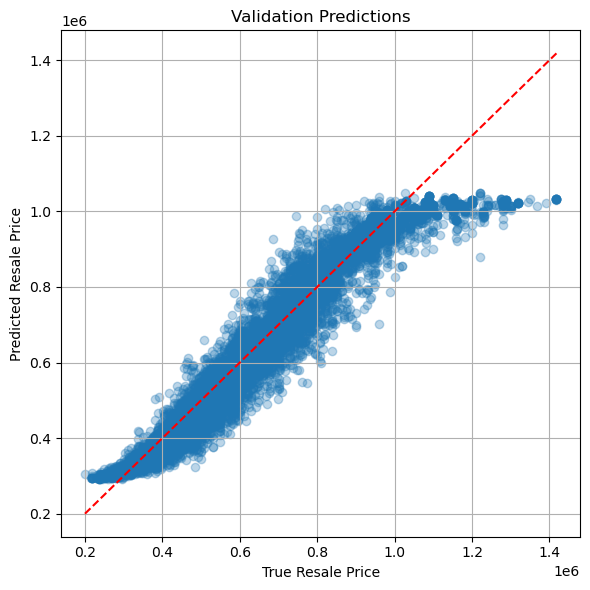

In [54]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = LSTMEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = LSTMDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = Seq2SeqModel(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")

plot_predictions(val_trues, val_preds)


In [55]:
def build_static_embedding(row):
    return np.concatenate([
        np.array(row['town_one_hot']),
        np.array(row['flat_type_one_hot']),
        np.array(row['storey_category_one_hot']),
        np.array(row['flat_model_one_hot']),
        np.array(row['hdb_classification_one_hot']),
        np.array(row['street_name_embed']),
        np.array([row['lease_commence_date'] / 2025.0]),         # normalize year
        np.array([row['floor_area_category'] / 200.0])           # normalize area
    ])

df_final["static_embedding"] = df_final.apply(build_static_embedding, axis=1)

In [56]:
def recommend_profitable_flats(town, budget, purchase_year, forecast_years, df, model, device):
    model.eval()
    purchase_cutoff = pd.to_datetime(f"{purchase_year}-12-31")
    df_filtered = df[(df['town'] == town) & (df['month'] <= purchase_cutoff) & (df['resale_price'] <= budget)]
  

    df_filtered.columns.tolist()
    results = []
    with torch.no_grad():

        # Compute mean and std specific to the filtered data
        resale_mean_local = df_filtered['resale_price'].mean()
        resale_std_local = df_filtered['resale_price'].std()

        df_filtered = df_filtered.copy()  # avoid SettingWithCopyWarning
        df_filtered['static_tuple'] = df_filtered['static_embedding'].apply(lambda x: tuple(x))

      

        for key, group in df_filtered.groupby("static_tuple"):
            group = group.sort_values("month").reset_index(drop=True)

            if len(group) < 12:
                continue  # skip if not enough months for sliding window

            # Simulate 12-month time window from most recent data before purchase_year
            x_window = group.iloc[-12:][["resale_price_normalized", "remaining_lease_normalized"]].values  # [12, 2]
            static_embed = group.iloc[-1]["static_embedding"]  # 
            x_static_repeated = np.tile(static_embed, (12, 1))  # 
            x_combined = np.concatenate([x_window, x_static_repeated], axis=1)  # 

            x_tensor = torch.tensor(x_combined, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 12, 66]
            static_tensor = torch.tensor(static_embed, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 64]

            # Forecast resale prices
            forecast_len = max(forecast_years)
            forecast = model(x_tensor, static_tensor, target_len=forecast_len, teacher_forcing_inputs=None, teacher_forcing_ratio=0.0)
            forecast = forecast.squeeze(0).cpu().numpy()  # [forecast_len]

            # Denormalize predictions
            forecast_denorm = forecast * resale_std_local + resale_mean_local

            for year in forecast_years:
                future_price = forecast_denorm[year - 1]
                buy_price = group.iloc[-1]["resale_price"]
                profit = future_price - buy_price
                results.append({
                    "street_name": group.iloc[-1]["street_name"] if "street_name" in group.columns else str(key),
                    "flat_type": group.iloc[-1]["flat_type"] if "flat_type" in group.columns else "Unknown",
                    "purchase_price": buy_price,
                    "year": purchase_year + year,
                    "predicted_price": future_price,
                    "estimated_profit": profit
                })

    # Sort by highest average profit per street
    result_df = pd.DataFrame(results)
    print(result_df.empty)
    print(result_df.columns)
    top_streets = result_df.groupby("street_name")["estimated_profit"].mean().sort_values(ascending=False).head(10)

    
    print("\n🏆 Top 10 Profitable Streets:")
    print(top_streets)
 
    return result_df, top_streets


In [57]:
results_df_lstm, top_streets_lstm = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 24    157613.281250
TAMPINES ST 42     55993.378472
TAMPINES AVE 4     52416.468750
TAMPINES AVE 9     45629.776042
TAMPINES ST 11     41436.812500
TAMPINES AVE 8     38413.000000
TAMPINES ST 84     35685.104167
TAMPINES ST 41     32673.864583
SIMEI ST 1         29411.078125
TAMPINES ST 21     25937.862500
Name: estimated_profit, dtype: float64


# GRU

In [58]:
class GRUEncoder(nn.Module):
    def __init__(self, non_static_dim, static_embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        input_dim = non_static_dim + static_embedding_dim
        self.gru = nn.GRU(
            input_size=input_dim, # 2 +76 (dynamic + static) = 78 
            hidden_size=hidden_dim, # Hyperparameter
            num_layers=num_layers, # Hyperparameter
            batch_first=True # input tensor (x) shape is set to [batch_size, sequence_length, input_dim]
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        # out is the hidden state for all time steps
        # hidden = hidden state for the last time step
        out, hidden = self.gru(x)
        return hidden  # Return full hidden & cell states

In [59]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_dim, static_embedding_dim, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = output_dim + static_embedding_dim  # 1 + 76
        self.gru = nn.GRU(input_size=self.input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, target_len, static_embed, hidden, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):
        """
        Inputs:
        - target_len: length of the target sequence:, how many resale prices to predict ? 
        - static_embed: [B, 64] - static embedding repeated for each time step 
        - hidden: state from encoder
        - teacher_forcing_inputs: [B, target_len] optional ground truth inputs values 
        - teacher_forcing_ratio: how often to use ground truth vs predicted values 
        Returns:
        - outputs: [B, target_len]
        """
        batch_size = static_embed.size(0) # Batch size 
        output_dim = self.fc.out_features # 1 
        outputs = []

        # First input: zero resale price
        input_step = torch.zeros(batch_size, 1, output_dim).to(static_embed.device)

        # Run the decoder target_len times 
        # If we want a prediction 5 years ahead, target_len = 60
        for t in range(target_len):
            # Concatenate static embedding to every input
            static_t = static_embed.unsqueeze(1)  # [B, 1, 76]
            lstm_input = torch.cat([input_step, static_t], dim=2)  # [B, 1, 1+76]

            out, hidden = self.gru(lstm_input, hidden)  # out: [B, 1, H]
            output = self.fc(out)  # [B, 1, 1]
            outputs.append(output.squeeze(1))  # [B, 1] → squeeze time dim

            # Decide whether to use teacher forcing
            # When training, we can use teacher forcing to improve convergence
            # When doing inference into the future, we use the predicted value
            if teacher_forcing_inputs is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_step = teacher_forcing_inputs[:, t].unsqueeze(1).unsqueeze(-1)  # [B, 1, 1]
            else:
                input_step = output  # Autoregressive prediction 

        return torch.cat(outputs, dim=1)  # [B, target_len]

Epoch 1 | Train Loss: 0.5337 | Val Loss: 0.2016 | MAE: 56347.46 | R²: 0.81
Epoch 2 | Train Loss: 0.1163 | Val Loss: 0.1029 | MAE: 43061.92 | R²: 0.90
Epoch 3 | Train Loss: 0.0815 | Val Loss: 0.2753 | MAE: 85594.64 | R²: 0.74
Epoch 4 | Train Loss: 0.0682 | Val Loss: 0.1127 | MAE: 45804.75 | R²: 0.89
Epoch 5 | Train Loss: 0.0664 | Val Loss: 0.0839 | MAE: 41090.75 | R²: 0.92
Epoch 6 | Train Loss: 0.0613 | Val Loss: 0.1220 | MAE: 52717.42 | R²: 0.88
Epoch 7 | Train Loss: 0.0591 | Val Loss: 0.0578 | MAE: 31543.12 | R²: 0.95
Epoch 8 | Train Loss: 0.0572 | Val Loss: 0.1270 | MAE: 54117.83 | R²: 0.88
Epoch 9 | Train Loss: 0.0561 | Val Loss: 0.0953 | MAE: 48710.55 | R²: 0.91
Epoch 10 | Train Loss: 0.0534 | Val Loss: 0.0748 | MAE: 36515.43 | R²: 0.93


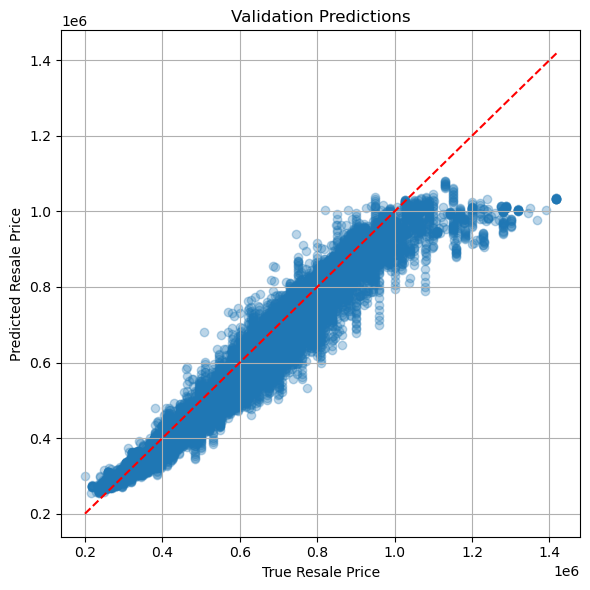

In [60]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = GRUEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = GRUDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = Seq2SeqModel(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")

plot_predictions(val_trues, val_preds)

In [63]:
results_df_gru, top_streets_gru = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES AVE 4    96816.189583
TAMPINES ST 24    93663.687500
TAMPINES ST 22    64426.013889
TAMPINES AVE 8    47527.135417
TAMPINES ST 41    34478.156250
TAMPINES ST 21    32418.093750
TAMPINES ST 12    29132.934028
TAMPINES ST 72    24555.427083
TAMPINES ST 11    18492.604167
TAMPINES ST 84    17570.708333
Name: estimated_profit, dtype: float64


# GRU-to-LSTM

In [ ]:
class GRUtoLSTM(nn.Module):
    def __init__(self, encoder: GRUEncoder, decoder: LSTMDecoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        return self.decoder(
            target_len=target_len,
            static_embed=static_embed,
            hidden=(hidden, hidden),
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

Epoch 1 | Train Loss: 0.7390 | Val Loss: 0.7404 | MAE: 125004.27 | R²: 0.32
Epoch 2 | Train Loss: 0.6777 | Val Loss: 0.7321 | MAE: 108020.89 | R²: 0.33
Epoch 3 | Train Loss: 0.6761 | Val Loss: 0.7024 | MAE: 106102.93 | R²: 0.35
Epoch 4 | Train Loss: 0.6965 | Val Loss: 0.9594 | MAE: 121534.74 | R²: 0.12
Epoch 5 | Train Loss: 0.7155 | Val Loss: 0.7812 | MAE: 112622.34 | R²: 0.28
Epoch 6 | Train Loss: 0.7044 | Val Loss: 0.7111 | MAE: 105621.95 | R²: 0.34
Epoch 7 | Train Loss: 0.6659 | Val Loss: 0.6789 | MAE: 107419.16 | R²: 0.37
Epoch 8 | Train Loss: 0.6680 | Val Loss: 0.8664 | MAE: 116143.99 | R²: 0.20
Epoch 9 | Train Loss: 0.6638 | Val Loss: 0.8023 | MAE: 109751.98 | R²: 0.26
Epoch 10 | Train Loss: 0.6643 | Val Loss: 0.7189 | MAE: 104649.77 | R²: 0.34


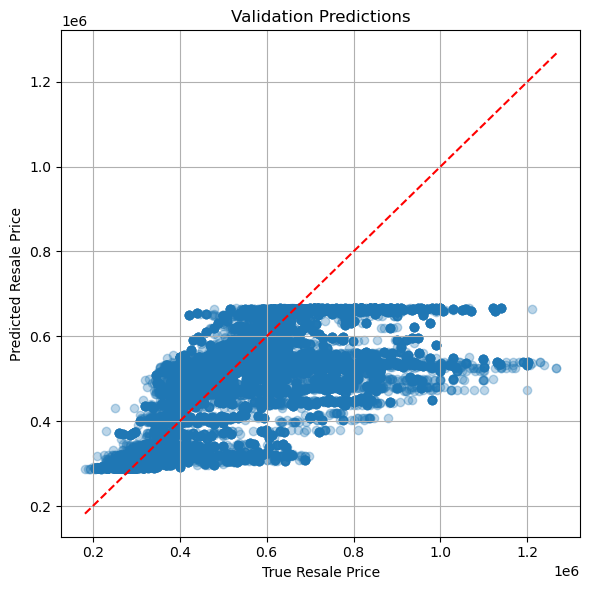

In [ ]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = GRUEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = LSTMDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = GRUtoLSTM(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")

plot_predictions(val_trues, val_preds)


In [ ]:
results_df_gru2lstm, top_streets_gru2lstm = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
  
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 33    212596.093750
TAMPINES ST 12    169306.131944
TAMPINES AVE 4    157501.968750
TAMPINES ST 82    141868.153646
TAMPINES ST 42    140218.423611
TAMPINES ST 41    133028.208333
TAMPINES ST 43    123380.223958
TAMPINES ST 34    113910.885417
TAMPINES ST 24    110396.947917
TAMPINES AVE 5    109733.718750
Name: estimated_profit, dtype: float64


# LSTM-to-GRU

In [ ]:
class LSTMtoGRU(nn.Module):
    def __init__(self, encoder: GRUEncoder, decoder: LSTMDecoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        hidden = torch.cat(hidden, dim=-1)
        # print(hidden.shape)
        return self.decoder(
            target_len=target_len,
            static_embed=static_embed,
            hidden=hidden,
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

Epoch 1 | Train Loss: 0.1479 | Val Loss: 0.2292 | MAE: 75928.55 | R²: 0.79
Epoch 2 | Train Loss: 0.0481 | Val Loss: 0.2104 | MAE: 72157.41 | R²: 0.81
Epoch 3 | Train Loss: 0.0435 | Val Loss: 0.0988 | MAE: 44489.48 | R²: 0.91
Epoch 4 | Train Loss: 0.0442 | Val Loss: 0.0508 | MAE: 28928.97 | R²: 0.95
Epoch 5 | Train Loss: 0.0411 | Val Loss: 0.0511 | MAE: 29474.12 | R²: 0.95
Epoch 6 | Train Loss: 0.0390 | Val Loss: 0.1139 | MAE: 48111.46 | R²: 0.90
Epoch 7 | Train Loss: 0.0358 | Val Loss: 0.1371 | MAE: 54757.90 | R²: 0.87
Epoch 8 | Train Loss: 0.0328 | Val Loss: 0.0482 | MAE: 27405.32 | R²: 0.96
Epoch 9 | Train Loss: 0.0308 | Val Loss: 0.0619 | MAE: 33320.34 | R²: 0.94
Epoch 10 | Train Loss: 0.0311 | Val Loss: 0.0592 | MAE: 34219.86 | R²: 0.95


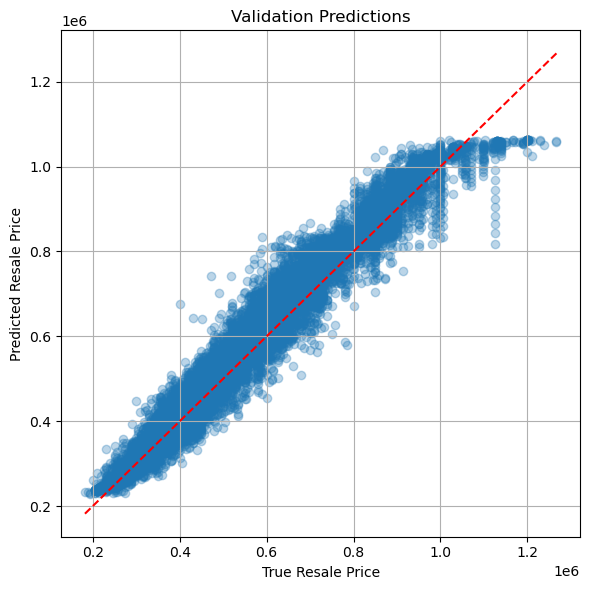

In [ ]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = LSTMEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = GRUDecoder(
    hidden_dim=hidden_dim*2,    # doubled due to hidden & cells state concatenation from LSTM
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = LSTMtoGRU(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")

plot_predictions(val_trues, val_preds)


In [ ]:
print("Available columns:", df.columns.tolist())

Available columns: ['month', 'town', 'flat_type', 'street_name', 'storey_category', 'floor_area_category', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'hdb_classification', 'town_one_hot', 'flat_type_one_hot', 'storey_category_one_hot', 'flat_model_one_hot', 'hdb_classification_one_hot', 'street_name_embed', 'row_tuple', 'static_vector', 'static_tuple', 'static_embedding', 'resale_price_normalized', 'remaining_lease_normalized']


In [ ]:
results_df_lstm2gru, top_streets_lstm2gru = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES AVE 4    280785.786458
TAMPINES ST 24    252571.083333
TAMPINES ST 41    241434.020833
TAMPINES ST 21    238932.600000
TAMPINES ST 82    213254.854167
TAMPINES AVE 9    173838.828125
SIMEI ST 1        168070.416667
TAMPINES ST 83    165944.479167
TAMPINES ST 71    165109.500000
TAMPINES ST 11    141744.229167
Name: estimated_profit, dtype: float64
